# The Storm-Relative Hodograph 
Creator: Cameron J. Nixon

In [8]:
# Imports software
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import matplotlib.colors as cm
from matplotlib.colors import LinearSegmentedColormap, to_rgba
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from datetime import datetime, timedelta
from netCDF4 import num2date
from siphon.ncss import NCSS
from siphon.catalog import TDSCatalog
from scipy import interpolate
import metpy.calc as mpcalc
from metpy.units import units
import metpy.plots as mpplots
from metpy.plots import ctables, Hodograph
import cdsapi
from urllib.request import urlopen
import xarray as xr
import pytz

##### NOTICE – RAP vs. ERA5 data
By default, this code pulls RAP data from Unidata / THREDDs. This server is prone to semi-frequent errors. If you encounter issues pulling RAP data, it is likely not your fault (no matter what the errors tell you). Wait a couple days and try again. 

When RAP data is unavailable, this code will try pulling the ECMWF ERA5 data from Copernicus. This server is generally more reliable. ERA5 data can be pulled from all the way back to 1950 (no change in user input is necessary — just type in the year/month/day as normal). However, to "unlock" this ERA5 compatibility, you may need to set up an account with cdsapi here: https://cds.climate.copernicus.eu/api-how-to.

Happy hodographing!

In [9]:
# Choose mode
mode = 'reanalysis'
# mode = 'realtime'

if (mode == 'reanalysis'):
    # Choose date
    year  = '2020'
    month = '05'
    day   = '22'
    time  = '0200' # 0000-2300
    fcst  = '000' # 000
    # Choose center latitude/longitude
    center_lat = 36.92
    center_lon = -101.15

elif (mode == 'realtime'):
    forecast_hour = 2
    center_lat = 33
    center_lon = -99

# Choose hodograph type
# hodo_type = 'Storm-Relative'
# hodo_type = 'Rotated Shear-Relative'
# hodo_type = 'Rotated Storm-Relative'
hodo_type = 'Ground-Relative'

# Choose motion
motion = 'R'
mirror = 'no'

In [10]:
# TIME CALIBRATION

# Find nearest
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

hour = time[0:2]+str('00')
minute = time[2:]

# Create datetime object
datetime_input = datetime(int(year), int(month), int(day), int(hour[0:2]), int(minute))

# Find closest model time
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
           +timedelta(hours=t.minute//30))
datetime_model = hour_rounder(datetime_input)

# Overwrite model date/time
year = datetime_model.strftime('%Y')
month = datetime_model.strftime('%m')
day = datetime_model.strftime('%d')
hour = datetime_model.strftime('%H')+'00'

print('> TIME CALIBRATION SUCCESSFUL')

> TIME CALIBRATION SUCCESSFUL


In [11]:
# MODEL DOWNLOAD

# Define map area for query
north_lat = center_lat + .5
south_lat = center_lat - .5
west_lon = center_lon - .5
east_lon = center_lon + .5
        
# Reanalysis
if (mode == 'reanalysis'):
    fcst = '000'
            
    if (datetime_input > datetime(2005, 5, 1) and center_lon < -67 and center_lon > -130 and center_lat < 57 and center_lat > 21):

        try:
            # DATA DOWNLOADING (RAP / RUC)
            url1 = ['https://www.ncei.noaa.gov/thredds/ncss/grid/model-rap130anl/','https://www.ncei.noaa.gov/thredds/ncss/grid/model-ruc130anl/',
                    'https://www.ncei.noaa.gov/thredds/ncss/grid/model-rap252anl/','https://www.ncei.noaa.gov/thredds/ncss/grid/model-ruc252anl/']
            url2 = ['https://www.ncei.noaa.gov/thredds/ncss/grid/model-rap130anl-old/','https://www.ncei.noaa.gov/thredds/ncss/grid/model-ruc130anl-old/',
                    'https://www.ncei.noaa.gov/thredds/ncss/grid/model-rap252anl-old/','https://www.ncei.noaa.gov/thredds/ncss/grid/model-ruc252anl-old/']
            suffix = ['/rap_130_','/ruc2anl_130_',
                      '/rap_252_','/ruc2anl_252_']
            filetype = ['.grb2','.grb2',
                        '.grb2','.grb']
            gridspacing = [13000,13000,20000,20000]
            mslp_vars = ['MSLP_MAPS_System_Reduction_msl','MSLP_MAPS_System_Reduction_msl',
                         'MSLP_MAPS_System_Reduction_msl','Mean_Sea_Level_Pressure_MAPS_System_Reduction_msl']
            pres_s_vars = ['Pressure_surface','Pressure_surface',
                           'Pressure_surface','Pressure_surface']
            hght_vars = ['Geopotential_height_isobaric','Geopotential_height_isobaric',
                         'Geopotential_height_isobaric','Geopotential_height_isobaric']
            hght_s_vars = ['Geopotential_height_surface','Geopotential_height_surface',
                           'Geopotential_height_surface','Geopotential_height_surface']
            temp_vars = ['Temperature_isobaric','Temperature_isobaric',
                           'Temperature_isobaric','Temperature_isobaric']
            temp_s_vars = ['Temperature_height_above_ground','Temperature_height_above_ground',
                           'Temperature_height_above_ground','Temperature_height_above_ground']
            relh_vars = ['Relative_humidity_isobaric','Relative_humidity_isobaric',
                         'Relative_humidity_isobaric','Relative_humidity_isobaric']           
            relh_s_vars = ['Relative_humidity_height_above_ground','Relative_humidity_height_above_ground',
                         'Relative_humidity_height_above_ground','Relative_humidity_height_above_ground']   
            dwpt_s_vars = ['Dewpoint_temperature_height_above_ground','Dewpoint_temperature_height_above_ground',
                           'Dewpoint_temperature_height_above_ground','Dew_point_temperature_height_above_ground']  
            uwnd_vars = ['u-component_of_wind_isobaric','u-component_of_wind_isobaric', 
                         'u-component_of_wind_isobaric','u-component_of_wind_isobaric']
            uwnd_s_vars = ['u-component_of_wind_height_above_ground','u-component_of_wind_height_above_ground', 
                         'u-component_of_wind_height_above_ground','u-component_of_wind_height_above_ground']
            vwnd_vars = ['v-component_of_wind_isobaric','v-component_of_wind_isobaric', 
                         'v-component_of_wind_isobaric','v-component_of_wind_isobaric']
            vwnd_s_vars = ['v-component_of_wind_height_above_ground','v-component_of_wind_height_above_ground',
                         'v-component_of_wind_height_above_ground','v-component_of_wind_height_above_ground']
            cape_vars = ['Convective_available_potential_energy_surface','Convective_available_potential_energy_surface',
                         'Convective_available_potential_energy_surface','Convective_Available_Potential_Energy_surface']
            omega_vars = ['Vertical_velocity_pressure_isobaric','Vertical_velocity_pressure_isobaric',
                          'Vertical_velocity_pressure_isobaric','Vertical_velocity_pressure_isobaric']
            
            data = None
            try:
                i=0
                try:
                    data = NCSS(url1[i]+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+suffix[i]+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+filetype[i])
                    model = 'RAP'
                except:
                    data = NCSS(url2[i]+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+suffix[i]+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+filetype[i])
                    model = 'RAP'
            except:
                try:
                    i=1
                    try:
                        data = NCSS(url1[i]+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+suffix[i]+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+filetype[i])
                        model = 'RUC'
                    except:
                        data = NCSS(url2[i]+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+suffix[i]+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+filetype[i])
                        model = 'RUC'
                except:
                    try:
                        i = 2
                        try:
                            data = NCSS(url1[i]+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+suffix[i]+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+filetype[i])
                            model = 'RAP'
                        except:
                            data = NCSS(url2[i]+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+suffix[i]+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+filetype[i])
                            model = 'RAP'
                    except:
                        i = 3
                        try:
                            data = NCSS(url1[i]+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+suffix[i]+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+filetype[i])
                            model = 'RUC'
                        except:
                            data = NCSS(url2[i]+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+suffix[i]+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+filetype[i])
                            model = 'RUC'
            if data:
                # Initiates query
                query = data.query()
                # Subsets by data
                query.variables(mslp_vars[i],
                                pres_s_vars[i],
                                hght_vars[i],
                                hght_s_vars[i],
                                temp_vars[i],
                                temp_s_vars[i],
                                relh_vars[i],
                                relh_s_vars[i],
                                dwpt_s_vars[i],
                                uwnd_vars[i],
                                uwnd_s_vars[i],
                                vwnd_vars[i],
                                vwnd_s_vars[i],
                                cape_vars[i],
                                omega_vars[i]).add_lonlat()
                # Subsets by area
                query.lonlat_box(west_lon,east_lon,south_lat,north_lat)
                # Gets data
                data_model = data.get_data(query)
                        
            if data_model:
                # Defines data
                mslp   = data_model.variables[mslp_vars[i]][0,:,:]/100
                pres   = [100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
                pres_s = data_model.variables[pres_s_vars[i]][0,:,:]/100
                hght   = data_model.variables[hght_vars[i]][0,:,:,:]
                hght_s = data_model.variables[hght_s_vars[i]][0,:,:]
                temp   = data_model.variables[temp_vars[i]][0,:,:,:]-273.15
                temp_s = data_model.variables[temp_s_vars[i]][0,0,:,:]-273.15
                relh   = data_model.variables[relh_vars[i]][0,:,:,:]
                relh_s = data_model.variables[relh_s_vars[i]][0,0,:,:]
                dwpt   = mpcalc.dewpoint_from_relative_humidity(np.array(temp)*units('degC'),(np.array(relh)/100)*units('percent')).m
                dwpt_s = data_model.variables[dwpt_s_vars[i]][0,0,:,:]-273.15
                uwnd   = data_model.variables[uwnd_vars[i]][0,:,:,:]*1.94384
                uwnd_s = data_model.variables[uwnd_s_vars[i]][0,0,:,:]*1.94384
                vwnd   = data_model.variables[vwnd_vars[i]][0,:,:,:]*1.94384
                vwnd_s = data_model.variables[vwnd_s_vars[i]][0,0,:,:]*1.94384
                cape   = data_model.variables[cape_vars[i]][0,:,:]
                omega   = data_model.variables[omega_vars[i]][0,:,:,:]
                
                # Gets dimension data
                lats = 1000*(data_model.variables[data_model.variables[mslp_vars[i]].dimensions[1]][:])
                lons = 1000*(data_model.variables[data_model.variables[mslp_vars[i]].dimensions[2]][:])
                time = data_model.variables[data_model.variables[mslp_vars[i]].dimensions[0]]
                # Set up times
                vtimes = num2date(time[:],time.units)
                
                # Model time
                validtime = datetime(int(vtimes[0].strftime('%Y')), int(vtimes[0].strftime('%m')), int(vtimes[0].strftime('%d')), int(vtimes[0].strftime('%H')), 0, 0, 0)
                validtime = validtime.replace(tzinfo=pytz.UTC)
                
                data_model.close()
                
                gridspace = gridspacing[i] # meters
                
                success = True
            else:
                success = False
        except:
            
            # DATA DOWNLOADING (ERA5)
            url_pressurelevels = 'reanalysis-era5-pressure-levels'
            url_singlelevels = 'reanalysis-era5-single-levels'
                     
            dataset = url_pressurelevels
            # download_flag = 'false'
            c = cdsapi.Client()
            
            #parameters to extract 
            parameters = {
                    'product_type':'reanalysis',
                    'variable': ['temperature', 'geopotential', 'relative humidity', 'U WIND COMPONENT', 'V WIND COMPONENT', 'w'],
                    'pressure_level': [
                        '100', '125',
                        '150', '175', '200',
                        '225', '250', '300',
                        '350', '400', '450',
                        '500', '550', '600',
                        '650', '700', '750',
                        '775', '800', '825',
                        '850', '875', '900',
                        '925', '950', '975',
                        '1000',
                    ],
                    'year': year, 
                    'month': month,
                    'day': day,
                    'time': f'{hour[0:2]}:00',
                    'format': 'netcdf',
                    'area': [north_lat, west_lon, south_lat, east_lon]
                    }
            
            dataset2 = url_singlelevels
            # download_flag = 'false'
            c2 = cdsapi.Client()
            
            #parameters to extract 
            parameters2 = {
                    'product_type':'reanalysis',
                    'variable': ['2m_temperature', '2m_dewpoint_temperature', 'surface_pressure', '10u', '10v', 'z', 'msl', 'cape'],
                    'year': year, 
                    'month': month,
                    'day': day,
                    'time': f'{hour[0:2]}:00',
                    'format': 'netcdf',
                    'area': [north_lat, west_lon, south_lat, east_lon]
                    }
            
            # retrieves the path to the file
            fl = c.retrieve(dataset, parameters)# download the file 
            print('downloaded from '+dataset)
            fl2 = c2.retrieve(dataset2, parameters2)
            print('downloaded from '+dataset2)
            # if download_flag:
            fl.download("./output.nc")
            fl2.download("./output.nc")# load into memory
            with urlopen(fl.location) as f:
                ds = xr.open_dataset(f.read())
            with urlopen(fl2.location) as f:
                ds2 = xr.open_dataset(f.read())
                
            ds2 = ds2.rename({'z':'zs','sp':'ps','t2m':'ts','d2m':'tds','u10':'us','v10':'vs'})
                
            data_ERA5 = xr.merge([ds,ds2])
            
            mslp   = np.array(data_ERA5['msl'][0,:])/100
            pres   = np.array(data_ERA5['level'])
            pres_s = np.array(data_ERA5['ps'][0,:])/100
            hght   = np.array(data_ERA5['z'][0,:,:,:])/9.80665
            hght_s = np.array(data_ERA5['zs'][0,:])/9.80665
            temp   = np.array(data_ERA5['t'][0,:,:,:])-273.15
            temp_s = np.array(data_ERA5['ts'][0,:])-273.15
            dwpt_s = np.array(data_ERA5['tds'][0,:])-273.15
            relh   = np.array(data_ERA5['r'][0,:,:,:])
            relh_s = mpcalc.relative_humidity_from_dewpoint(temp_s*units('degC'),dwpt_s*units('degC'))*100
            dwpt   = mpcalc.dewpoint_from_relative_humidity(temp*units('degC'),(relh/100)*units('percent')).m
            # dwpt   = (243.04*(np.log(relh/100)+((17.625*temp)/(243.04+temp)))/(17.625-np.log(relh/100)-((17.625*temp)/(243.04+temp))))
            uwnd   = np.array(data_ERA5['u'][0,:,:,:])*1.94384
            uwnd_s = np.array(data_ERA5['us'][0,:])*1.94384
            vwnd   = np.array(data_ERA5['v'][0,:,:,:])*1.94384
            vwnd_s = np.array(data_ERA5['vs'][0,:])*1.94384
            omega  = np.array(data_ERA5['w'][0,:,:,:])
            cape   = np.array(data_ERA5['cape'][0,:])
            
            # Gets dimension data
            lats = ds['latitude'][:]
            lons = ds['longitude'][:]
            time = ds['time']
            
            lats = np.array(lats.values)
            lons = np.array(lons.values)
            
            fcst = '000'
            model = 'ERA5'
            gridspace = 31000 # meters
            
            # Model time
            vtimes = np.datetime64(str(time[0].values))
            ns = 1e-9 # number of seconds in a nanosecond
            validtime = datetime.utcfromtimestamp(vtimes.astype(int) * ns)
            validtime = validtime.replace(tzinfo=pytz.UTC)
   
            
    elif (datetime(int(year), int(month), int(day)) > datetime(1950, 1, 1)) or success == False:

        if (datetime(int(year), int(month), int(day)) > datetime(1959, 1, 1)):
            # DATA DOWNLOADING (ERA5)
            url_pressurelevels = 'reanalysis-era5-pressure-levels'
            url_singlelevels = 'reanalysis-era5-single-levels'
        else:
            url_pressurelevels = 'reanalysis-era5-pressure-levels-preliminary-back-extension'
            url_singlelevels = 'reanalysis-era5-single-levels-preliminary-back-extension'

        dataset = url_pressurelevels
        # download_flag = 'false'
        c = cdsapi.Client()
  
        #parameters to extract 
        parameters = {
                'product_type':'reanalysis',
                'format': 'netcdf',
                'variable': ['temperature', 'geopotential', 'relative humidity', 'U WIND COMPONENT', 'V WIND COMPONENT', 'w'],
                'pressure_level': [
                    '100', '125',
                    '150', '175', '200',
                    '225', '250', '300',
                    '350', '400', '450',
                    '500', '550', '600',
                    '650', '700', '750',
                    '775', '800', '825',
                    '850', '875', '900',
                    '925', '950', '975',
                    '1000',
                ],
                'year': year, 
                'month': month,
                'day': day,
                'time': f'{hour[0:2]}:00',
                'format': 'netcdf',
                'area': [north_lat, west_lon, south_lat, east_lon]
                }
        
        dataset2 = url_singlelevels
        # download_flag = 'false'
        c2 = cdsapi.Client()
        
        #parameters to extract 
        parameters2 = {
                'product_type':'reanalysis',
                'variable': ['2m_temperature', '2m_dewpoint_temperature', 'surface_pressure', '10u', '10v', 'z', 'msl', 'cape'],
                'year': year, 
                'month': month,
                'day': day,
                'time': f'{hour[0:2]}:00',
                'format': 'netcdf',
                'area': [north_lat, west_lon, south_lat, east_lon]
                }
        
        # retrieves the path to the file
        fl = c.retrieve(dataset, parameters)# download the file 
        print('downloaded from '+dataset)
        fl2 = c2.retrieve(dataset2, parameters2)
        print('downloaded from '+dataset2)
        # if download_flag:
        fl.download("./output.nc")
        fl2.download("./output.nc")# load into memory
        with urlopen(fl.location) as f:
            ds = xr.open_dataset(f.read())
        with urlopen(fl2.location) as f:
            ds2 = xr.open_dataset(f.read())
            
        ds2 = ds2.rename({'z':'zs','sp':'ps','t2m':'ts','d2m':'tds','u10':'us','v10':'vs'})
            
        data_ERA5 = xr.merge([ds,ds2])
        
        mslp   = np.array(data_ERA5['msl'][0,:])/100
        pres   = np.array(data_ERA5['level'])
        pres_s = np.array(data_ERA5['ps'][0,:])/100
        hght   = np.array(data_ERA5['z'][0,:,:,:])/9.80665
        hght_s = np.array(data_ERA5['zs'][0,:])/9.80665
        temp   = np.array(data_ERA5['t'][0,:,:,:])-273.15
        temp_s = np.array(data_ERA5['ts'][0,:])-273.15
        dwpt_s = np.array(data_ERA5['tds'][0,:])-273.15
        relh   = np.array(data_ERA5['r'][0,:,:,:])
        relh_s = mpcalc.relative_humidity_from_dewpoint(temp_s*units('degC'),dwpt_s*units('degC'))*100
        dwpt   = mpcalc.dewpoint_from_relative_humidity(temp*units('degC'),(relh/100)*units('percent')).m
        # dwpt   = (243.04*(np.log(relh/100)+((17.625*temp)/(243.04+temp)))/(17.625-np.log(relh/100)-((17.625*temp)/(243.04+temp))))
        uwnd   = np.array(data_ERA5['u'][0,:,:,:])*1.94384
        uwnd_s = np.array(data_ERA5['us'][0,:])*1.94384
        vwnd   = np.array(data_ERA5['v'][0,:,:,:])*1.94384
        vwnd_s = np.array(data_ERA5['vs'][0,:])*1.94384
        omega  = np.array(data_ERA5['w'][0,:,:,:])
        cape   = np.array(data_ERA5['cape'][0,:])
        
        # Gets dimension data
        lats = ds['latitude'][:]
        lons = ds['longitude'][:]
        time = ds['time']
        
        lats = np.array(lats.values)
        lons = np.array(lons.values)
        
        fcst = '000'
        model = 'ERA5'
        gridspace = 31000 # meters
        
        # Model time
        vtimes = np.datetime64(str(time[0].values))
        ns = 1e-9 # number of seconds in a nanosecond
        validtime = datetime.utcfromtimestamp(vtimes.astype(int) * ns)
        validtime = validtime.replace(tzinfo=pytz.UTC)

# Real-time
elif (mode == 'realtime'):
        
    # DATA DOWNLOADING (RAP / RUC)
    for attempt in range(50):
        try:
            # Choose date (random)
            year  = '2019'
            month = '03'
            day   = '15'
            hour  = '0200' # 0000-2300
            fcst  = '000' # 000
            # Downloads RAP data
            url = 'https://www.ncei.noaa.gov/thredds/ncss/grid/model-rap130anl-old/'
            data = NCSS(url+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_130_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb2')
            # Initiates query
            query = data.query()
            # Subsets by data
            query.variables(
                            'Geopotential_height_surface'
                            ).add_lonlat()
            # Subsets by area
            query.lonlat_box(west_lon,east_lon,south_lat,north_lat)
            # Gets data
            data_RAP = data.get_data(query)
            # Defines data
            hght_s  = data_RAP.variables['Geopotential_height_surface'][0,:,:]
            
            print('downloaded from '+url)
            data_RAP.close
        except:
            print('server failure (THREDDS) — cannot download sfc height data')
        else:
            break
    else:
        hght_s = None
        print('server down (THREDDS) — cannot download sfc height data')
        
    # DATA DOWNLOADING (RAP)
    url = 'http://thredds.ucar.edu/thredds/catalog/grib/NCEP/RAP/CONUS_13km/latest.xml'
    cat = TDSCatalog(url)
    latest_ds = list(cat.datasets.values())[0]
    ncss = NCSS(latest_ds.access_urls['NetcdfSubset'])
    # Initiates query
    query = ncss.query()
    # Find start time
    start_time = ncss.metadata.time_span['begin']
    # Find forecast hour closest to current time
    if (forecast_now == 'now'):
        # Define current time
        import time
        from time import gmtime, strftime
        now = datetime.utcnow()
        now = now.replace(tzinfo=pytz.UTC)
        def hour_rounder(t):
            # Rounds to nearest hour by adding a timedelta hour if minute >= 30
            return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
                   +timedelta(hours=t.minute//30))
        actualtime = hour_rounder(now).strftime('%H')
        runtime = int(start_time[11:13])
        if (runtime != actualtime):
            for i in range(1,12,1):
                if (int(runtime) == int(actualtime) - i) | (int(runtime) == int(actualtime) + (24-i)):
                    forecast_hour = forecast_hour+i
                    break
                else: 
                    forecast_hour = forecast_hour+0
        else: forecast_hour = 0
        if (forecast_hour < 0):
            forecast_hour = 0

    start_hour = datetime.strptime(start_time, '%Y-%m-%dT%H:%M:%SZ')
    fhour = start_hour+timedelta(hours=forecast_hour)
    # Subsets by time
    query.time(fhour).accept('netcdf4')
    # Subsets by data
    query.variables('MSLP_MAPS_System_Reduction_msl',
                    'Pressure_surface',
                    'Geopotential_height_isobaric',
                    'Temperature_isobaric',
                    'Relative_humidity_isobaric',
                    'Temperature_height_above_ground',
                    'Relative_humidity_height_above_ground',
                    'u-component_of_wind_height_above_ground', 'v-component_of_wind_height_above_ground', 
                    'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric',
                    'Convective_available_potential_energy_surface',
                    'Vertical_velocity_pressure_isobaric'
                    )
    # Subsets by area
    query.add_lonlat().lonlat_box(west_lon,east_lon,south_lat,north_lat)
    # Gets data
    data_RAP = ncss.get_data(query)
    
    # Defines RAP data
    mslp   = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'][0,:,:]/100
    pres   = [100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
    pres_s = data_RAP.variables['Pressure_surface'][0,:,:]/100
    hght   = data_RAP.variables['Geopotential_height_isobaric'][0,:,:,:]
    if not hght_s[0,0]:
        hght_s = hght[-1,:,:]
    temp   = data_RAP.variables['Temperature_isobaric'][0,:,:,:]-273.15
    temp_s = data_RAP.variables['Temperature_height_above_ground'][0,0,:,:]-273.15
    relh   = data_RAP.variables['Relative_humidity_isobaric'][0,:,:,:]
    relh_s = data_RAP.variables['Relative_humidity_height_above_ground'][0,0,:,:]
    dwpt   =  mpcalc.dewpoint_from_relative_humidity(np.array(temp)*units('degC'),(np.array(relh)/100)*units('percent')).m
    dwpt_s = (mpcalc.dewpoint_from_relative_humidity(np.array(temp_s)*units('degC'),np.array(relh_s/100)).m)
    uwnd   = data_RAP.variables['u-component_of_wind_isobaric'][0,:,:,:]*1.94384
    uwnd_s = data_RAP.variables['u-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
    vwnd   = data_RAP.variables['v-component_of_wind_isobaric'][0,:,:,:]*1.94384
    vwnd_s = data_RAP.variables['v-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
    cape   = data_RAP.variables['Convective_available_potential_energy_surface'][0,:,:]
    omega   = data_RAP.variables['Vertical_velocity_pressure_isobaric'][0,:,:,:]
        
    # Gets dimension data
    lats = 1000*(data_RAP.variables[data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[1]][:])
    lons = 1000*(data_RAP.variables[data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[2]][:])
    time = data_RAP.variables[data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[0]]
    # Set up times
    vtimes = num2date(time[:],time.units)
    
    # Model time
    validtime = datetime(int(vtimes[0].strftime('%Y')), int(vtimes[0].strftime('%m')), int(vtimes[0].strftime('%d')), int(vtimes[0].strftime('%H')), 0, 0, 0)
    validtime = validtime.replace(tzinfo=pytz.UTC)
    
    data_RAP.close()

    print('downloaded from '+url)
    model = 'RAP'
    gridspace = 13000 # meters
    
# Local time
from timezonefinder import TimezoneFinder
tf = TimezoneFinder()
tz = tf.timezone_at(lng=center_lon, lat=center_lat)
localDatetime = validtime.astimezone(pytz.timezone(tz))
if ('-' in localDatetime.strftime('%Z')) or ('+' in localDatetime.strftime('%Z')):
    localtime = localDatetime.strftime("%I:%M%p UTC%Z")
else:
    localtime = localDatetime.strftime("%I:%M%p %Z")

print('> DATA DOWNLOAD SUCCESSFUL')

> DATA DOWNLOAD SUCCESSFUL


In [12]:
# Set up projection
crs = ccrs.PlateCarree()

# Set up array of latitude / longitude values and transform to native projection.
clons, clats = np.meshgrid(lons, lats)
tlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=-95, central_latitude=25,standard_parallels=(25.,25.),globe=ccrs.Globe(datum='WGS84',ellipse='sphere')),clons,clats)
tlons = tlatlons[:,:,0]
tlats = tlatlons[:,:,1]

# Find array index closest to location
location = (center_lon,center_lat)
# calculate distance between center lat/lon and analog cases (Haversine)
def haversine(lon_arr, lat_arr, lon_point, lat_point): 
    distance = 6371*(2*np.arcsin(np.sqrt(np.sin((np.radians(lat_arr)-np.radians(lat_point))/2)**2 + np.cos(np.radians(lat_point)) * np.cos(np.radians(lat_arr)) * np.sin((np.radians(lon_arr)-np.radians(lon_point))/2)**2)))
    return distance
location_distance = haversine(tlons,tlats,location[0],location[1])
location_index = np.where(location_distance == np.min(location_distance))

In [13]:
"""
get_sfc_index

This function takes an array of height values and finds the index before the first positive value

Input: height_arr (array-like object of height values)

Output: index (int indicating the index just before the first positive height value. If -1 is returned,
               a positive index could not be found.)
"""

def get_sfc_index(height_arr):
    
    i = 0
    
    # Search the array for the sfc index
    while i < len(height_arr):
        if height_arr[i] >= 0:
            return i
            
        else:
            i += 1
            
    # Did not find a positive index
    return -1

"""
make_sfc_based

This function takes an array and a valid index in that array, then returns a copy of the
array beginning at the provided index i.e., chops off below-ground values

Inputs: arr (array-like object)
        index (int indicating the index where copying will begin)

Output: mod_arr (numpy array with the values from arr[index:len(arr)])
"""

def make_sfc_based(arr, sfc_val, sfc_index):
    
    # Initialize an empty numpy array as the modified array
    mod_arr = np.empty(len(arr) - sfc_index)
    
    # Insert the sfc and higher values into the modified array
    i = 0
    while i < len(mod_arr):
        mod_arr[i] = arr[i + sfc_index]
        i = i + 1
    
    # Inserts surface values
    mod_arr = np.insert(mod_arr, 0, sfc_val)
    return mod_arr

# Finds Upper-level Values
p = [100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
p = p[::-1]
ps = mslp[location_index[0],location_index[1]][0]*units.hPa
h = hght[::-1,location_index[0],location_index[1]][:,0]-hght_s[location_index[0],location_index[1]][0]
hs = hght_s[location_index[0],location_index[1]][0]*units.meter
u = uwnd[::-1,location_index[0],location_index[1]][:,0]
v = vwnd[::-1,location_index[0],location_index[1]][:,0]
T = temp[::-1,location_index[0],location_index[1]]
Td = (243.04*(np.log(relh[:,location_index[0],location_index[1]]/100)+((17.625*temp[:,location_index[0],location_index[1]])/(243.04+temp[:,location_index[0],location_index[1]])))/(17.625-np.log(relh[:,location_index[0],location_index[1]]/100)-((17.625*temp[:,location_index[0],location_index[1]])/(243.04+temp[:,location_index[0],location_index[1]]))))
Td = Td[::-1]
RH = relh[:,location_index[0],location_index[1]]/100

# Finds Surface Values
ps = mslp[location_index[0],location_index[1]][0]
hs = 0
us = uwnd_s[location_index[0],location_index[1]][0]
vs = vwnd_s[location_index[0],location_index[1]][0]
Ts = temp_s[location_index[0],location_index[1]][0]-273.15
Tds = dwpt_s[location_index[0],location_index[1]][0]-273.15
RHs = relh_s[location_index[0],location_index[1]][0]

# Creates Arrays for Vertical Profile
sfc_index = get_sfc_index(h)
h_new = make_sfc_based(h, hs, sfc_index)
p_new = make_sfc_based(p, ps, sfc_index)
u_new = make_sfc_based(u, us, sfc_index)
v_new = make_sfc_based(v, vs, sfc_index)
T_new = make_sfc_based(T, Ts, sfc_index)
Td_new = make_sfc_based(Td, Tds, sfc_index)
RH_new = make_sfc_based(RH, RHs, sfc_index)

h = h_new*units.meter
p = p_new*units.hPa
u = u_new*units.knot
v = v_new*units.knot
T = T_new*units.degC
Td = Td_new*units.degC
RH = RH_new*units.percent

d = mpcalc.wind_direction(u, v)
spd = mpcalc.wind_speed(u, v)

In [14]:
# Interpolates data
dz = 250 

# determines interpolation levels
soundingtop_hght = h[-1].m
toplvl = int(soundingtop_hght/dz)*dz
numlvls = int(toplvl/dz)
interp_lvls = np.linspace(0,toplvl,numlvls+1)

# initializes new arrays
unew = np.zeros((len(interp_lvls)))
vnew = np.zeros((len(interp_lvls)))
Tnew = np.zeros((len(interp_lvls)))
Tdnew = np.zeros((len(interp_lvls)))
RHnew = np.zeros((len(interp_lvls)))
hnew = np.zeros((len(interp_lvls)))
pnew = np.zeros((len(interp_lvls)))

unew[0] = u[0].m
vnew[0] = v[0].m
Tnew[0] = T[0].m
Tdnew[0] = Td[0].m
RHnew[0] = RH[0].m
hnew[0] = h[0].m
pnew[0] = p[0].m

# interpolates existing data
u_interp = interpolate.interp1d(h, u)
v_interp = interpolate.interp1d(h, v)
T_interp = interpolate.interp1d(h, T)
Td_interp = interpolate.interp1d(h, Td)
RH_interp = interpolate.interp1d(h, RH)
h_interp = interpolate.interp1d(h, h)
p_interp = interpolate.interp1d(h, p)

# creates arrays of interpolated data
for i in range(1,len(unew),1):
    unew[i] = u_interp(dz*i)
for i in range(1,len(vnew),1):
    vnew[i] = v_interp(dz*i)
for i in range(1,len(Tnew),1):
    Tnew[i] = T_interp(dz*i)
for i in range(1,len(Tdnew),1):
    Tdnew[i] = Td_interp(dz*i)
for i in range(1,len(RHnew),1):
    RHnew[i] = RH_interp(dz*i)
for i in range(1,len(hnew),1):
    hnew[i] = h_interp(dz*i)
for i in range(1,len(pnew),1):
    pnew[i] = p_interp(dz*i)

u = np.array(unew)*units('knot')
v = np.array(vnew)*units('knot')
T = np.array(Tnew)*units('degC')
Td = np.array(Tdnew)*units('degC')
RH = np.array(RHnew)*units('percent')
h = np.array(hnew)*units('meter')
p = np.array(pnew)*units('hPa')

d = mpcalc.wind_direction(u, v)
spd = mpcalc.wind_speed(u, v)

# Applies sfc values
try:
    if (Tsfc):
        T[0] = (Tsfc*units('degF')).to('degC')
    if (Tdsfc):
        Td[0] = (Tdsfc*units('degF')).to('degC')
    if (spdsfc):
        u[0],v[0] = mpcalc.wind_components(spdsfc*units('knot'),dirsfc*units('degrees'))
except:
    pass

# Defines significant levels
try:
    h0 = np.where(h==0.*units('meter'))[0][0]
    h05 = np.where(h==500.*units('meter'))[0][0]
    h1 = np.where(h==1000.*units('meter'))[0][0]
    h15 = np.where(h==1500.*units('meter'))[0][0]
    h2 = np.where(h==2000.*units('meter'))[0][0]
    h25 = np.where(h==2500.*units('meter'))[0][0]
    h3 = np.where(h==3000.*units('meter'))[0][0]
    h4 = np.where(h==4000.*units('meter'))[0][0]
    h5 = np.where(h==5000.*units('meter'))[0][0]
    h6 = np.where(h==6000.*units('meter'))[0][0]
    h7 = np.where(h==7000.*units('meter'))[0][0]
    h8 = np.where(h==8000.*units('meter'))[0][0]
    h9 = np.where(h==9000.*units('meter'))[0][0]
    h10 = np.where(h==10000.*units('meter'))[0][0]
    h11 = np.where(h==11000.*units('meter'))[0][0]
    h12 = np.where(h==12000.*units('meter'))[0][0]
    h13 = np.where(h==13000.*units('meter'))[0][0]
    h14 = np.where(h==14000.*units('meter'))[0][0]
    h155 = np.where(h==15000.*units('meter'))[0][0]
except:
    pass

In [15]:
# Calculates storm motions
rightmover,leftmover,meanwind = mpcalc.bunkers_storm_motion(p,u,v,h)[:]
rightmoveru = rightmover[0]
rightmoverv = rightmover[1]
leftmoveru = leftmover[0]
leftmoverv = leftmover[1]
meanwindu = meanwind[0]
meanwindv = meanwind[1]

# rightmoveru = 32*units('knot')
# rightmoverv = 0*units('knot')

# Calculates storm-relative hodographs
ur = u-rightmoveru
vr = v-rightmoverv
ul = u-leftmoveru
vl = v-leftmoverv

# Calculates rotated storm-relative hodographs
rightmoverangle = -1*((np.pi)-(np.degrees(mpcalc.wind_direction(rightmoveru,rightmoverv))))
urmsr = ur*np.cos(rightmoverangle) - vr*np.sin(rightmoverangle)
vrmsr = ur*np.sin(rightmoverangle) + vr*np.cos(rightmoverangle)
rightmoverdir = np.degrees(mpcalc.wind_direction(rightmoveru,rightmoverv))
rightmoverspd = np.sqrt(rightmoveru**2+rightmoverv**2)

In [16]:
RM_u = rightmoveru
RM_v = rightmoverv

# Defines hodograph origin / relativity
if (hodo_type == 'Rotated Shear-Relative'):
    shearu = u[h3]-u[h0]
    shearv = v[h3]-v[h0]
    shearangle = (mpcalc.wind_direction(shearu,shearv)-np.pi).m
    unew = (u*np.cos(shearangle) - v*np.sin(shearangle))
    unew = unew - unew[h0]
    vnew = (u*np.sin(shearangle) + v*np.cos(shearangle))
    vnew = vnew - vnew[h0]
elif (hodo_type == 'Rotated Storm-Relative'):
    if (motion == 'R'):
        storm_u = RM_u
        storm_v = RM_v
        if (mirror == 'yes'):
            usr = u-storm_u
            vsr = vbulk-storm_v
            stormangle = -1*((np.pi)-(np.degrees(mpcalc.wind_direction(storm_u,storm_v))))
            unew = usr*np.cos(stormangle) - vsr*np.sin(stormangle)
            vnew = usr*np.sin(stormangle) + vsr*np.cos(stormangle)
            unew = unew*-1
        elif (mirror == 'no'):
            usr = u-storm_u
            vsr = v-storm_v
            stormangle = -1*((np.pi)-(np.degrees(mpcalc.wind_direction(storm_u,storm_v))))
            unew = usr*np.cos(stormangle) - vsr*np.sin(stormangle)
            vnew = usr*np.sin(stormangle) + vsr*np.cos(stormangle)
    elif (motion == 'L'):
        storm_u = LM_u
        storm_v = LM_v
        stormangle = np.zeros(len(u))
        if (mirror == 'yes'):
            usr = u-storm_u
            vsr = v-storm_v
            stormangle = -1*((np.pi)-(np.degrees(mpcalc.wind_direction(storm_u,storm_v))))
            unew = usr*np.cos(stormangle) - vsr*np.sin(stormangle)
            vnew = usr*np.sin(stormangle) + vsr*np.cos(stormangle)
            unew = unew*-1
        elif (mirror == 'no'):
            usr = u-storm_u
            vsr = v-storm_v
            stormangle = -1*((np.pi)-(np.degrees(mpcalc.wind_direction(storm_u,storm_v))))
            unew = usr*np.cos(stormangle) - vsr*np.sin(stormangle)
            vnew = usr*np.sin(stormangle) + vsr*np.cos(stormangle)  
elif (hodo_type == 'Storm-Relative'):
    if (motion == 'R'):
        storm_u = RM_u
        storm_v = RM_v
        unew = u-RM_u
        vnew = v-RM_v    
    elif (motion == 'L'):
        storm_u = LM_u
        storm_v = LM_v
        unew = u-LM_u
        vnew = v-LM_v
else:
    unew = u
    vnew = v
                
ur = unew
vr = vnew

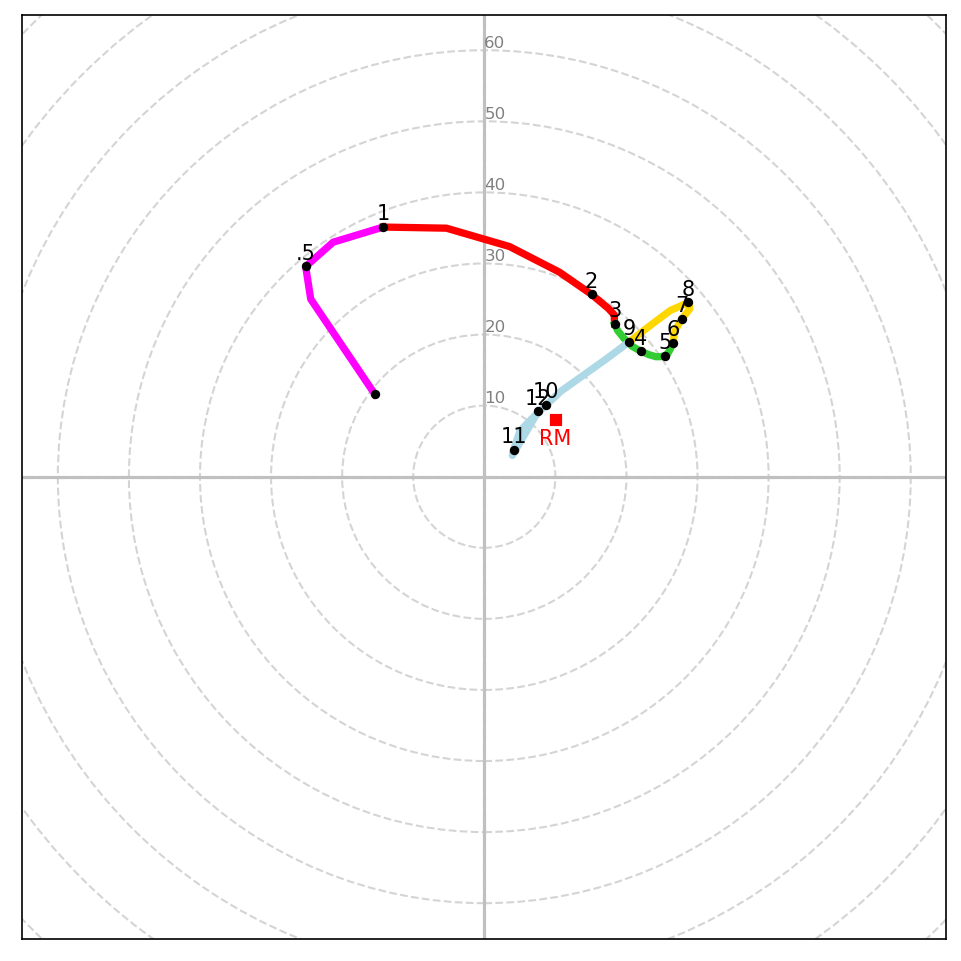

In [17]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = plt.subplot()
fig.patch.set_facecolor('white')

# Choose hodograph colors
# hodo_color = ['purple','red','darkorange','gold','#fff09f']
hodo_color = ['magenta','red','limegreen','gold','lightblue']

# Create a hodograph
if (hodo_type == 'Rotated Shear-Relative'):
    [ur,vr] = [vr,-ur]
    hod = mpplots.Hodograph(ax, component_range=100)
    hod.add_grid(increment=10,color='silver',alpha=0.67,zorder=0)
    ax.set_xlim(-75,75)
    ax.set_ylim(-75,75)
    ax.plot([-200,200],[0,0],color='silver',linestyle='-',linewidth=1.5,clip_on=True,alpha=1,zorder=0)
    ax.plot([0,0],[-200,200],color='silver',linestyle='-',linewidth=1.5,clip_on=True,alpha=1,zorder=0)
    # Plots tick marks inside the hodograph
    plt.xticks(np.arange(0,0,1))
    plt.yticks(np.arange(0,0,1))
    for i in range(10,80,10):
        plt.text(0,i,str(i),verticalalignment='bottom',horizontalalignment='left',fontsize=8,alpha=1,color='grey',clip_on=True)
        
elif (hodo_type == 'Ground-Relative'):
    hod = mpplots.Hodograph(ax, component_range=100)
    hod.add_grid(increment=10,color='silver',alpha=0.67,zorder=0)
    ax.set_xlim(-65,65)
    ax.set_ylim(-65,65)
    ax.plot([-200,200],[0,0],color='silver',linestyle='-',linewidth=1.5,clip_on=True,alpha=1,zorder=0)
    ax.plot([0,0],[-200,200],color='silver',linestyle='-',linewidth=1.5,clip_on=True,alpha=1,zorder=0)
    # Plots tick marks inside the hodograph
    plt.xticks(np.arange(0,0,1))
    plt.yticks(np.arange(0,0,1))
    for i in range(10,70,10):
        plt.text(0,i,str(i),verticalalignment='bottom',horizontalalignment='left',fontsize=8,alpha=1,color='grey',clip_on=True)
else:
    hod = mpplots.Hodograph(ax, component_range=100)
    hod.add_grid(increment=10,color='silver',alpha=0.67,zorder=0)
    ax.set_xlim(-60,60)
    ax.set_ylim(-60,60)
    ax.plot([-200,200],[0,0],color='silver',linestyle='-',linewidth=1.5,clip_on=True,alpha=1,zorder=0)
    ax.plot([0,0],[-200,200],color='silver',linestyle='-',linewidth=1.5,clip_on=True,alpha=1,zorder=0)
    # Plots tick marks inside the hodograph
    plt.xticks(np.arange(0,0,1))
    plt.yticks(np.arange(0,0,1))
    for i in range(10,70,10):
        ax.annotate(str(i),(0-i,0),xytext=(0,0),textcoords='offset pixels',clip_on=True,alpha=0.5,zorder=0)

# Plots storm motion
if (hodo_type == 'Storm-Relative'):
    hod.plot(0,0, color='red',marker='s',markersize=5,zorder=5,clip_on=True)
    ax.quiver(0,0,rightmoveru.m,rightmoverv.m,color='silver',angles='xy', scale_units='xy', scale=1,headwidth=5.3,headlength=5.3,width=.005,zorder=1,clip_on=True)
elif (hodo_type == 'Rotated Storm-Relative'):
    hod.plot(0,0, color='red',marker='s',markersize=5,zorder=5,clip_on=True)
    ax.quiver(0,0,0,rightmoverspd.m,color='silver',angles='xy', scale_units='xy', scale=1,headwidth=5.3,headlength=5.3,width=.005,zorder=1,clip_on=True)
elif (hodo_type == 'Ground-Relative'):
    hod.plot(rightmoveru.m,rightmoverv.m, color='red',marker='s',markersize=5,zorder=5,clip_on=True)
    hod.plot(rightmover[0].m,rightmover[1].m,color='red',marker='s',markersize=5,zorder=5,clip_on=True)
    ax.annotate('RM',(rightmoveru,rightmoverv),xytext=(0,-25),textcoords='offset pixels',horizontalalignment='center',clip_on=True,color='red')
#     hod.plot((rightmoveru.m+np.mean(ur[0:h1].m+1))/2,(rightmoverv.m+np.mean(vr[0:h1].m+1))/2,color='magenta',marker='s',markersize=5,zorder=5)
#     ax.annotate('DTM',((rightmoveru.m+np.mean(ur[0:h1].m+1))/2,(rightmoverv.m+np.mean(vr[0:h1].m+1))/2),xytext=(0,-25),textcoords='offset pixels',horizontalalignment='center',clip_on=True,color='magenta')
    # hod.plot(meanwindu.m,meanwindv.m, color='grey',marker='s',markersize=5,zorder=5)

# Plots hodograph
ax.plot(ur[0:h1+1].m, vr[0:h1+1].m, color=hodo_color[0], linewidth=3.5,clip_on=True)
ax.plot(ur[h1:h3+1].m, vr[h1:h3+1].m, color=hodo_color[1], linewidth=3.5,clip_on=True)
ax.plot(ur[h3:h6+1].m, vr[h3:h6+1].m, color=hodo_color[2], linewidth=3.5,clip_on=True)
ax.plot(ur[h6:h9+1].m, vr[h6:h9+1].m, color=hodo_color[3], linewidth=3.5,clip_on=True)
ax.plot(ur[h9:h12+1].m, vr[h9:h12+1].m, color=hodo_color[4], linewidth=3.5,clip_on=True)
    
# Hodograph height labels
hod.plot(ur[h05],vr[h05],color='black',marker='o',markersize=3.5,clip_on=True)
for i in (h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12):
    hod.plot(ur[i],vr[i],color='black',marker='o',markersize=3.5,clip_on=True)
ax.annotate(str('.5'),(ur[h05],vr[h05]),xytext=(0,7),textcoords='offset pixels',horizontalalignment='center',clip_on=True)
for i in (h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12):
    ax.annotate(str(int(round(h[i].m/1000,0))),(ur[i],vr[i]),xytext=(0,7),textcoords='offset pixels',horizontalalignment='center',clip_on=True) 

# Title
# plt.title(str(model)+' '+str(hour[0:2])+'Z F'+str(fcst[0:2])+' | VALID: ' +(vtimes[0].strftime('%Y'))+'-'+(vtimes[0].strftime('%m'))+'-'+(vtimes[0].strftime('%d'))+' '+(vtimes[0].strftime('%H00'))+'Z'+' | '+str(location[1])+','+str(location[0]), loc='left',fontsize=10)

if (hodo_type == 'Rotated Storm-Relative'):
    # INSET HODOGRAPH
    ax_hod = inset_axes(ax, '20%', '20%', loc='upper left')
    hod = Hodograph(ax_hod, component_range=70.)
    hod.add_grid(increment=10,color='silver',zorder=0,linewidth=0.5,alpha=0.5)

    hod.plot(u[0:h1+1].m, v[0:h1+1].m, color=hodo_color[0], linewidth=1.5,clip_on=True)
    hod.plot(u[h1:h3+1].m, v[h1:h3+1].m, color=hodo_color[1], linewidth=1.5,clip_on=True)
    hod.plot(u[h3:h6+1].m, v[h3:h6+1].m, color=hodo_color[2], linewidth=1.5,clip_on=True)
    hod.plot(u[h6:h9+1].m, v[h6:h9+1].m, color=hodo_color[3], linewidth=1.5,clip_on=True)
    hod.plot(u[h9:h12+1].m, v[h9:h12+1].m, color=hodo_color[4], linewidth=1.5,clip_on=True)

    hod.plot(rightmoveru.m,rightmoverv.m, color='red',marker='s',markersize=1.25,zorder=5,clip_on=True)
    hod.plot(leftmoveru.m,leftmoverv.m, color='dodgerblue',marker='s',markersize=1.25,zorder=5,clip_on=True)
    hod.plot(meanwindu.m,meanwindv.m, color='grey',marker='s',markersize=1.25,zorder=5,clip_on=True)
    
    ax_hod.xaxis.set_visible(False)
    ax_hod.yaxis.set_visible(False)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
# Titles
# ax.text(.01,.972, str(model)+' '+str(hour[0:2])+'Z F'+str(fcst[0:2])+' | VALID: ' +(vtimes[0].strftime('%Y'))+'-'+(vtimes[0].strftime('%m'))+'-'+(vtimes[0].strftime('%d'))+' '+(vtimes[0].strftime('%H00'))+'Z'+' | '+str(location[1])+','+str(location[0]),verticalalignment='bottom', horizontalalignment='left',transform=ax.transAxes,fontsize=7)
# ax.text(.992,.97, str(hodo_type)+' Hodograph',verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes)

# Save Sounding Data

In [18]:
# Writes sounding data to .txt file
f = open(str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(center_lat)+'_'+str(center_lon)+'_'+str(model)+'_'+str(hour[0:2])+'Z'+'_'+'F'+str(fcst[0:2])+'.txt','w')
f.write('%TITLE%\n')
f.write(str(model)+' '+str(year)[2:]+str(month)+str(day)+'/'+str(hour)+' '+str(hour[0:2])+'Z'+' '+'F'+str(fcst[0:2])+' '+str(center_lat)+','+str(center_lon)+'\n')
f.write(' \n')
f.write('{:>12.5s}{:>12.4s}{:>12.4s}{:>12.4s}{:>12.4s}{:>12.4s}\n'.format('LEVEL','HGHT','TEMP','DWPT','WDIR','WSPD'))
f.write('-------------------------------------------------------------------------\n')
f.write('%RAW%\n')
for i in range(0,len(p)):
    f.write('{:>12.4f}{:>12.4f}{:>12.4f}{:>12.4f}{:>12.4f}{:>12.4f}\n'.format(p[i].m,h[i].m,T[i].m,Td[i].m,mpcalc.wind_direction(u[i],v[i]).m,mpcalc.wind_speed(u[i],v[i]).m))
f.write('%END%\n')
f.close()